[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb) 

# Chapter 9 - Feature engineering and selection

So, we've gone through some basic feature pre-processing but that was just the tip of the iceberg. Feature engineering is the art of creating meaningful features from your data which is initially processed. You will likely have to use a combination of domain and statistical knowledge to get the most out of your variables. This includes techniques such as scaling and [transforming](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) (there are [other techniques](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) when dealing with time series data). It could also be the creation of new variables using some kind of combination of the variables that you have.

In this tutorial, we will discuss basic transformations for feature engineering and how to perform feature selection. As you know, your model should include all relevant variables. Any variables which don't help with predictability may cause overfitting and hamper model performance on new data. 

We will end with two useful tricks, importing from scripts and pipelines which should make your code quicker and cleaner to read.


Here are the contents point by point:
- Preliminaries
- Feature engineering
- Object Creation
- Feature selection
- Importing scripts
- Pipelines
- Exercises

# Preliminaries

We will begin as usual, by importing necessary libraries, settings and loading the data. 

In [62]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Load credit risk data in pre-processed format from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv' 
df = pd.read_csv(data_url)

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_train.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero
5737,43000.0,18388.0,64896.0,DebtCon,Other,20.0,0.0,0.0,207.06647,0.0,31.0,40.777878,True
5734,42900.0,8117.0,66731.0,HomeImp,Office,7.0,0.0,0.0,315.25482,0.0,19.0,13.312356,True
248,5500.0,65019.0,13770.0,HomeImp,Mgr,5.0,0.0,1.0,167.36667,1.0,8.0,34.818260,True
3480,18400.0,89101.0,118748.0,DebtCon,ProfExe,7.0,0.0,0.0,153.84976,2.0,21.0,21.762827,True
2488,14900.0,65303.0,84590.0,DebtCon,Office,6.0,0.0,0.0,121.06496,1.0,19.0,22.576824,True


In [63]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4768, 13) (1192, 13) (4768, 1) (1192, 1)


# Feature Engineering 

## Data preparation revisited

There is a small idea of how data preparation should look. This can however vary depending on the data with which you are working and the goal of your model. In general, you may **at least** want to follow these steps:

**1) Basic cleaning of null values, duplicates and outliers**

These values will have a big impact on how Python runs and how models are calculated. There were several approaches to deal with them. You could remove them, replace them with another value (indicator, mode, mean, max, min, etc), use a mini-model to impute them among other options. This has been done for the most part in this data set already. 

**2) Encode variables in the most appropriate way**

Check your dataframe using the method `.info()` . Are your continuous variables encoded as integers or floats? If they are type `object` then the column may need to be checked again for null values. It is good practice to change any categorical variables to the `category` data type as it increases processing time. Once you have confirmed that you will finalize the model with a categorical variable, it can be useful to one-hot encode it as described in step 5.

**3) Ensure variables fit statistical assumptions/model requirements**

The next steps are a bit more complex and will depend on which model you need to use. Your goal is to make sure your data will be accurately processed by your model. Note that a lot of statistical assumptions depend on normal distribution and scaling. For example, models like linear regression and K-Means are very sensitive to abitrarily large magnitudes. We will first examine ways to do that.

In this step, you may also want to remove features which are highly correlated to one another.

**4) Filter out variables with low predictive power**

The next set of transformations to the dataset will likely be one-hot encoding. Note that before this, you may want to check variables to see if they indicate they will contribute to your model. We will discuss filter methods to do just that. Note that some variables may only be effective in combination with others, so be careful with this step. 

**5) One-hot encode categorical variables**

Once you have decided to keep a categorical feature, it can be useful to one-hot encode the feature. Again, one-hot encoding means that instead of one categorical column, you have multiple dummies which represent possible category values. For example, if your categorical variable "transport" had the possible values of "car", "by foot" or "bus", you would split it into columns called "transport_car" and "transport_bus". "by foot" is indicated if neither of those have a value of 1 for that observation.

**6) Double check the model only includes appropriate variables**

Next, you may want to try a wrapper method or step-wise regression as another check to ensure you are only including relevant variables.

In many cases, you may have to repeat some of these steps several times. Remember the idea of **garbage in, garbage out**. If you feed a model nonsense, expect nonsense to come right back out. This is likely what will take the most of your time as a data scientist.

In [64]:
# Let's get a quick overview of the data types of each column and make sure they are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BAD        5960 non-null   bool   
 1   LOAN       5960 non-null   float64
 2   MORTDUE    5960 non-null   float64
 3   VALUE      5960 non-null   float64
 4   REASON     5960 non-null   object 
 5   JOB        5960 non-null   object 
 6   YOJ        5960 non-null   float64
 7   DEROG      5960 non-null   float64
 8   DELINQ     5960 non-null   float64
 9   CLAGE      5960 non-null   float64
 10  NINQ       5960 non-null   float64
 11  CLNO       5960 non-null   float64
 12  DEBTINC    5960 non-null   float64
 13  DEROGzero  5960 non-null   bool   
dtypes: bool(2), float64(10), object(2)
memory usage: 570.5+ KB


In [65]:
df['DEROG'].value_counts() # In the first few rows we see 'DEROG' may also be a Boolean, we can use .value_counts() on the column to check all possible values

0.0     5235
1.0      435
2.0      160
3.0       58
4.0       23
6.0       15
5.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

In [66]:
df['NINQ'].value_counts() # Checking 'NINQ' for the same reason as 'DEROG'

0.0    2531
1.0    1849
2.0     780
3.0     392
4.0     156
8.0      77
5.0      75
6.0      56
7.0      44
Name: NINQ, dtype: int64

Luckily, most of our variables are actually encoded the right way! Let's just change the two categorical variables to the correct category and do one last check.

In [67]:
# Let's change our two categorical variables to the correct type for our interim analysis

df['REASON'] = df['REASON'].astype('category')
df['JOB'] = df['JOB'].astype('category')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BAD        5960 non-null   bool    
 1   LOAN       5960 non-null   float64 
 2   MORTDUE    5960 non-null   float64 
 3   VALUE      5960 non-null   float64 
 4   REASON     5960 non-null   category
 5   JOB        5960 non-null   category
 6   YOJ        5960 non-null   float64 
 7   DEROG      5960 non-null   float64 
 8   DELINQ     5960 non-null   float64 
 9   CLAGE      5960 non-null   float64 
 10  NINQ       5960 non-null   float64 
 11  CLNO       5960 non-null   float64 
 12  DEBTINC    5960 non-null   float64 
 13  DEROGzero  5960 non-null   bool    
dtypes: bool(2), category(2), float64(10)
memory usage: 489.3 KB


## Scaling

Features will likely have arbitrary magnitudes. For example, a customer's spending range from 0 to 50,000 but a dummy variable about them may only take the value 0 or 1. For many algorithms, like the distance function in kMeans, this is problematic. The distance function will try to minimize differences among features using their raw values. This means that kMeans will focus on variables with arbitrarily high values like spending when that may not be as important as a dummy. One way to deal with this is to scale features so that they still vary but the values aren't arbitrarily higher. This way, all features will be considered equally. 

There are two major ways to scale: standardization and min-max scaling (also known as normalization).

### Standardization
After standardization, your feature will now be distributed about the mean feature value. If you believe you data is already normal (follows a Gaussian distribution) this could be the best option.

$$ X_{new} = \frac{X-\mu}{\sigma} $$

There is no maximum or minimum value here. This means that standardization does not deal with outliers. You may have a clearer picture of how extreme these outliers are after standardization.

### Min-Max Scaling
After min-max scaling, your variables will have a range of 0 and 1. Minimum feature values will become 0 and maximum values will be 1.

$$ X_{new} = \frac{X-X_{min}}{X_{max}-X_{min}} $$

This scaling is sometimes called normalization but you should note that it simply compacts the values of the features to be between 0 and 1, it does not change the overall shape of the data.


In [69]:
#standardization
def standardize(var):
  return (var - np.mean(var)) / np.std(var)

#min-max scaling
def min_max_scale(var):
  return (var - min(var)) / (max(var) - min(var))

Let's first look at how this variable looks before and after normalization and standardization using a box plot and then a histogram. **Note the axes of all of these plots.**

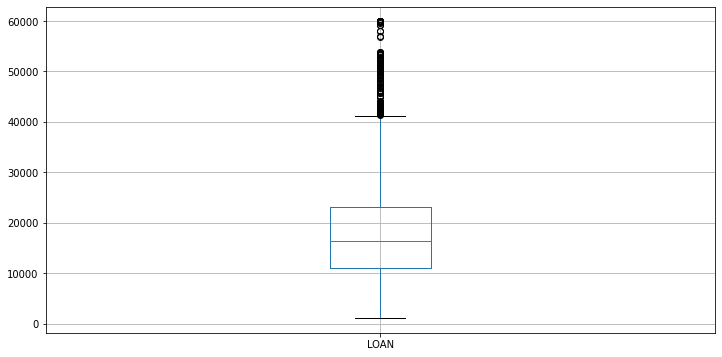

In [70]:
# raw variable 

X_train[['LOAN']].boxplot()

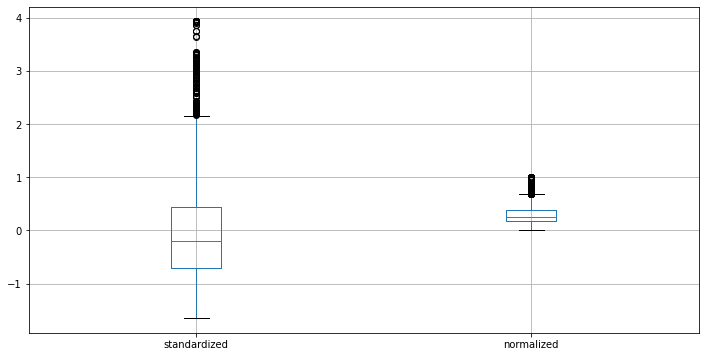

In [71]:
# comparison of the normalized vs. standardized variable (check axes for size)

loan_standardized = standardize(X_train['LOAN'])

loan_normalized = min_max_scale(X_train['LOAN'])

loans_scaled = pd.DataFrame({"standardized": loan_standardized, "normalized": loan_normalized,})

loans_scaled.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3baecd710>]],
      dtype=object)

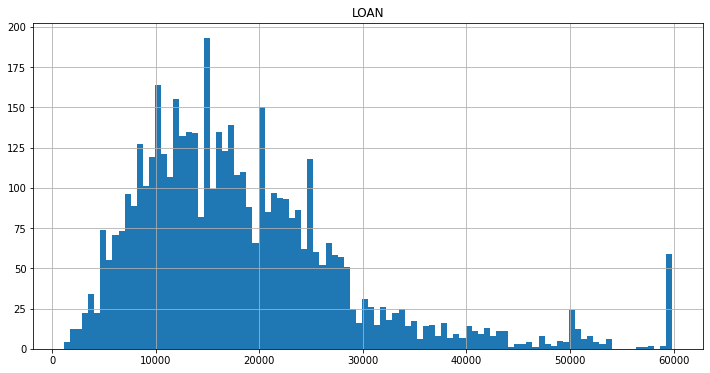

In [72]:
# histogram of raw variable

X_train[['LOAN']].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3bac39b38>,
      dtype=object)

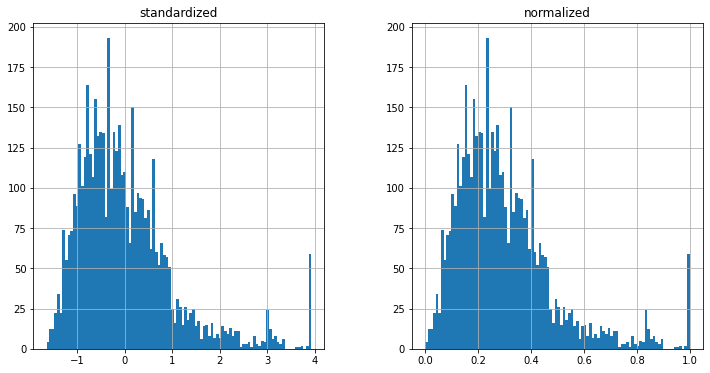

In [73]:
# comparison of the normalized vs. standardized variable (check axes for size)

loans_scaled.hist(bins=100)

As promised, the variables are now fit between something that resembles a bit more of a standard scaling. With min-max scaling or normalization, we have the variable ranging between 0 and 1. With standard scaling, we have the variable showing us its position relative to standard deviations. Note that in both of these examples, the variable was squeezed into a smaller range but did not change shape overall. There are ways to change its shape which we will explore next.

First, let's just quickly look at the standard way to do this with `sklearn`. We can just use the `MinMaxScaler()` and `StandardScaler` to do produce exactly what our custom functions did.

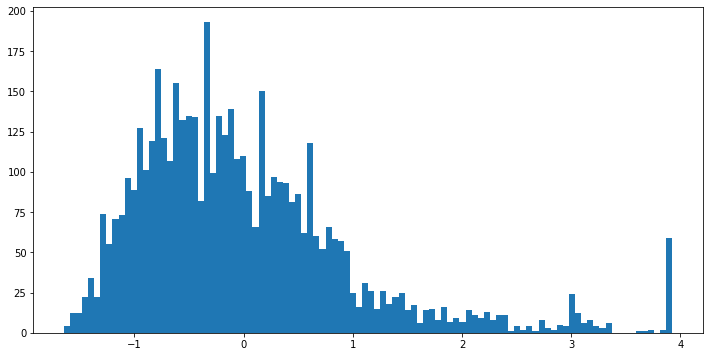

In [74]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
standardscaled = standardscaler.fit_transform(X_train[['LOAN']])
_ = plt.hist(standardscaled, bins=100)
plt.show()

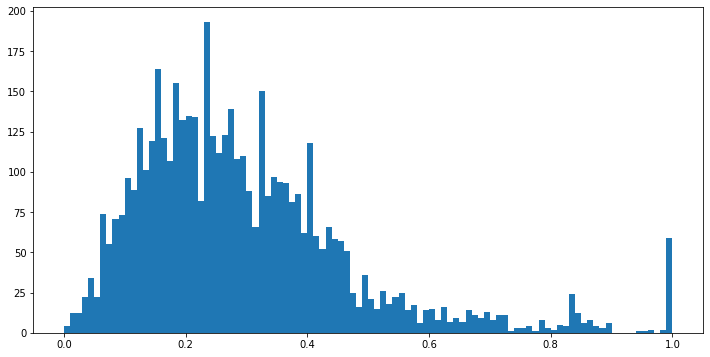

In [75]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
minmaxscaled = minmaxscaler.fit_transform(X_train[['LOAN']])

_ = plt.hist(minmaxscaled, bins=100)
plt.show()

## Checking features for normality
First, let's take a look at features. To determine which are the highest priority. We can do this by opening up a histogram of all floats in our dataset. As we can see, most of our vartiables do not appear to be normally distributed in the strictest sense. Most of them have long tails on only one side with no clearly defined single peak in the center.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3bacaf0f0>,
      dtype=object)

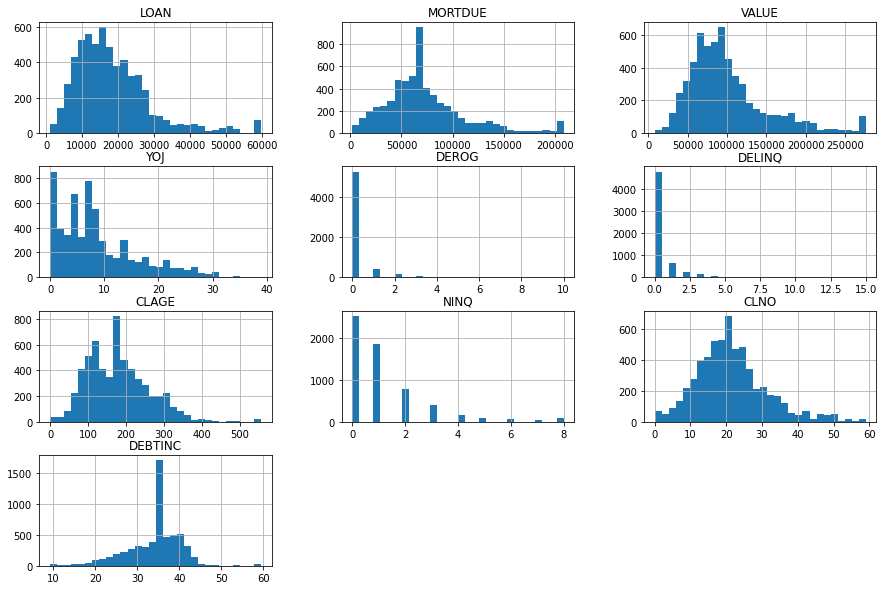

In [76]:
df.select_dtypes(include='float64').hist(bins=30, figsize=(15, 10))

In [77]:
# Choose a feature of interest and we'll take a deep dive into it

feature = df['LOAN'] 

One useful function for checking normality in variables is the `normaltest` from `scipy`. This function's documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). It outputs 2 numbers, the first is the sum of squares of the z-scores returned by a skewtest and kurtosistest. The second is a 2-sided chi2 probability hypothesis test. Thus, if the p-value is below 0.05, it is likely you do not have normally distributed data.

In [78]:
from scipy import stats
stats.normaltest(feature)

NormaltestResult(statistic=1603.6531776769357, pvalue=0.0)

 We can confirm using this function that the variable likely does not conform to a normal distribution and that min-max scaling (called normalization by some) doesn't help either.

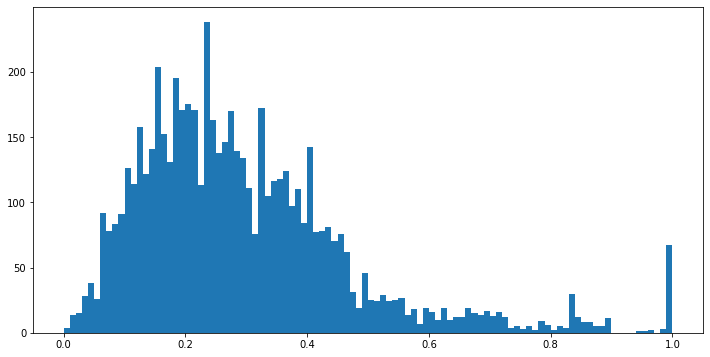

In [79]:
minmaxscaled_feature = minmaxscaler.fit_transform(pd.DataFrame(feature))

_ = plt.hist(minmaxscaled_feature, bins=100)
plt.show()

In [80]:
stats.normaltest(minmaxscaled_feature)

NormaltestResult(statistic=array([1603.65317768]), pvalue=array([0.]))

We can see problems a bit more clearly with quantile-quantile plot. Ideally, the blue line should match the red line (quantiles of a feature versus the quantiles/ppf of a distribution). If not, it is less likely that it comes from a normal distribution.

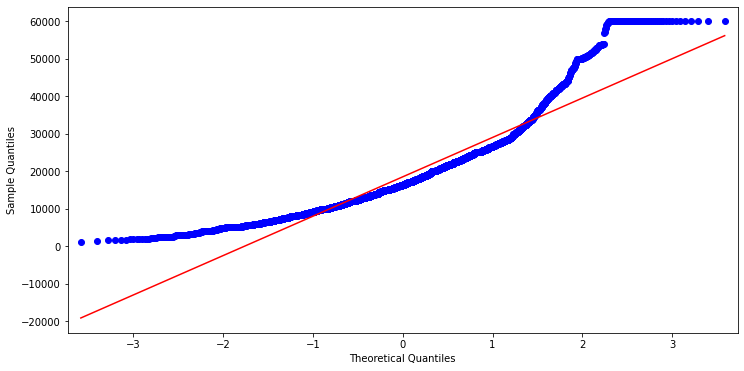

In [81]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot(feature, line='s')
pyplot.show()

## Common feature transformations for numeric data

Now, as we've seen we can change the magnitudes of our variables so that they are similar to one another. This ensures that variables with arbitrarily high values will not dominate an algorithm's objective of minimization. However, many statistical assumptions also rest on the fact that variables are linear and/or normally distributed. In real data, as you will see with our current data set, that is unfortunately rarely the case.

### Log Transformation
The use of logs is to create linearity from exponential relationships. This can greatly algorithms capture the fit of many variables. Remember that logs take only strictly positive variables. If you have any negative values, you will have to rescale your data, remove them or find another way to deal with them.

$ x^{(t)} = g(x) = log(x) $



### Box Cox Transformation
If your variable has a skewed tail, this can be problematic for the assumption on normality. You can try to correct this with a Box Cox transformation. This only works with strictly positive values (greater than 0). You can always rescale variables so they meet this criteria before putting them into this formula.

$
    x^{(t)} = g(x; \lambda) =
    \begin{cases}
      \frac{x^\lambda - 1}{\lambda}, & \text{if}\ \lambda \neq 0 \\
      log(x), & \text{otherwise}
    \end{cases}
$



### Yeo-Johnson Transformation
This formula is essentially a more elaborate version of Box Cox. It can take any numbers (0 and under is completely fine). 

$
    x^{(t)} = g(x; \lambda) =
    \begin{cases}
      \frac{(1+x)^\lambda - 1}{\lambda}, & \text{if}\ \lambda \neq 0 \ \text{and}\ x \geq 0 \\
      log(x+1), & \text{if}\ \lambda = 0 \ \text{and}\ x \geq 0 \\
      -\frac{(1-x)^{2-\lambda} - 1}{2-\lambda}, & \text{if}\ \lambda \neq 2 \ \text{and}\ x < 0\\
      -log(-x+1), & \text{if}\ \lambda = 2 \ \text{and}\ x < 0\\
    \end{cases}
$


## Testing transformations
The promise of the above power transformations is that they increase normality. Statisticians have developed ways to test whether a feature displays a normal distribution. A Python implementation for one such test is available in the `statsmodels` library. Afterwards, we'll use the function `normaltest()` to verify the efficacy of these transformations.

In [82]:
def box_cox_transform(var, power=0):
  try:
    assert (var > 0).all() # Box Cox is only defined for variables higher than 0
  except: 
    raise ValueError("Variable values must be strictly positive")
  if power == 0:
      var = np.log(var)
  else:
      var = (var ** power - 1) / power
  return var

In [83]:
def yeo_johnson_transform(var, power=1):
  if power == 0: # check lambda value
    var = np.where(var>=0, np.log(var + 1), -((-var + 1)**(2 - power) - 1) / (2 - power)) # two actions based on variable's value corresponding to function above
  elif power == 2:
    var = np.where(var>=0, ((var + 1)**power - 1) / power, -np.log(-var + 1))
  else:
    var = np.where(var>=0, ((var + 1)**power - 1) / power, -((-var + 1)**(2 - power) - 1) / (2 - power))
  return pd.Series(var)

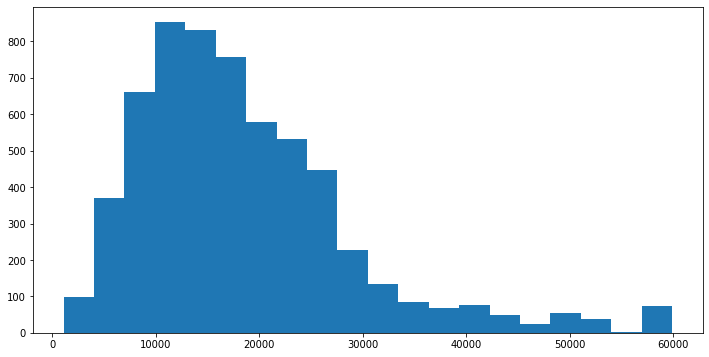

In [84]:
feature.hist(bins=20, grid=False) # still using feature of interest set before

In [85]:
# Adjust coefficient of Box Cox transformation on the feature to show plot below

bc1 = box_cox_transform(feature+1, power=0)
bc2 = box_cox_transform(feature+1, power=.5)
bc3 = box_cox_transform(feature+1, power=1)

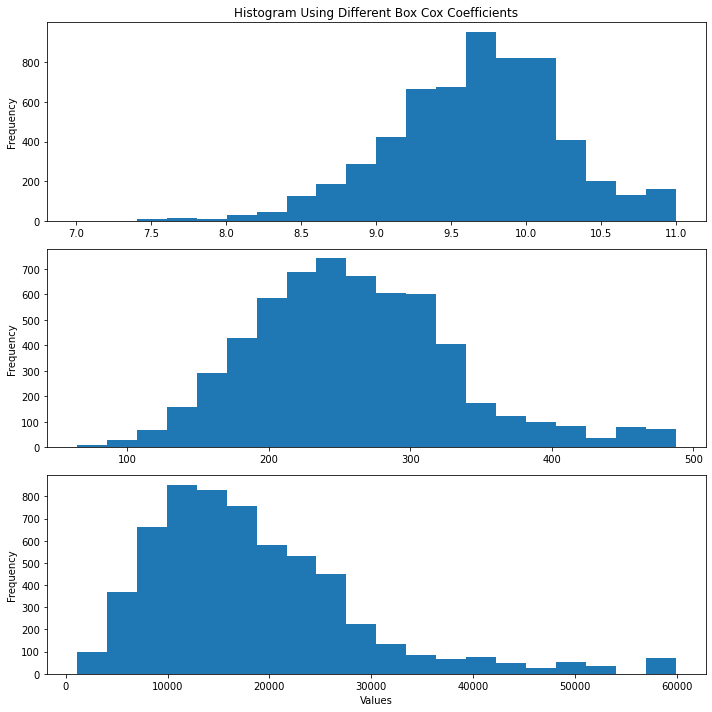

In [86]:
# Plot a histogram per coefficient of BC transformation

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.hist(bc1, bins=20)
ax2.hist(bc2, bins=20)
ax3.hist(bc3, bins=20)

ax1.set_title('Histogram Using Different Box Cox Coefficients')
ax1.set_label('Coefficient = 0')
ax1.set_ylabel('Frequency')

ax2.set_label('Coefficient = 0.5')
ax2.set_ylabel('Frequency')

ax3.set_label('Coefficient = 1')
ax3.set_xlabel('Values')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [87]:
# Adjust coefficient of YJ transformation on the feature to show plot below

yj1 = yeo_johnson_transform(feature, power=0)
yj2 = yeo_johnson_transform(feature, power=.5)
yj3 = yeo_johnson_transform(feature, power=1)

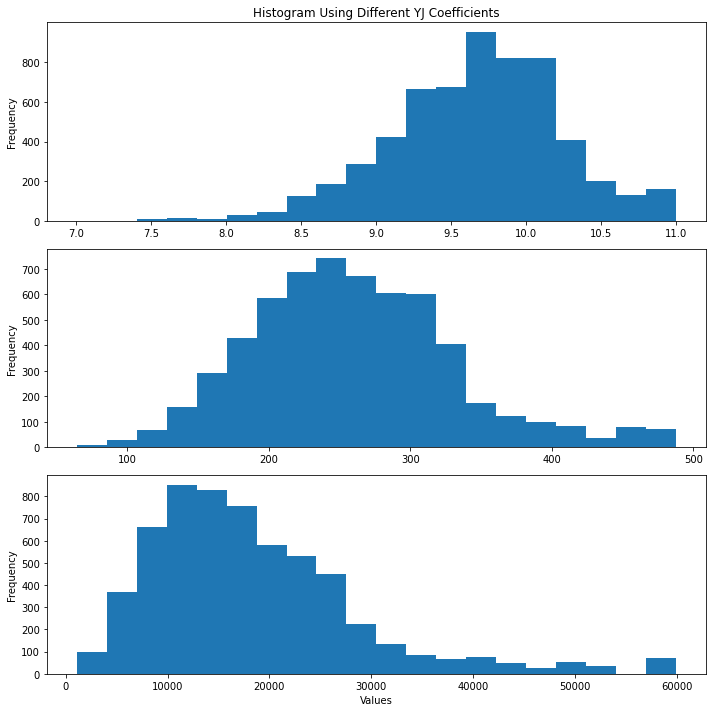

In [88]:
# Plot a histogram per coefficient of YJ transformation

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.hist(yj1, bins=20)
ax2.hist(yj2, bins=20)
ax3.hist(yj3, bins=20)

ax1.set_title('Histogram Using Different YJ Coefficients')
ax1.set_label('Coefficient = 0')
ax1.set_ylabel('Frequency')

ax2.set_label('Coefficient = 0.5')
ax2.set_ylabel('Frequency')

ax3.set_label('Coefficient = 1')
ax3.set_xlabel('Values')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Now that we've verified what these transformations do, we'll need to find an optimal. This is a task in the exercises to do manually. However, `scipy` functions actually do this on their own.

### Using `scipy` functions
Let's now use a pre-made function and see where it finds the true maximum point of normality. We can again use the `scipy` library which we have nicknamed `stats` to fit the feature and find the optimal lambda. Let's first start with Box Cox.

In [89]:
bc_fitted_feature, bc_fitted_lambda = stats.boxcox(feature+1) # Again, we are adding 1 because CLNO has 0s in it variables must be strictly positive for Box Cox

bc_fitted_lambda

0.19107151032822628

(array([  2.,   6.,  23.,  27.,  44., 107., 186., 251., 430., 569., 715.,
        818., 694., 727., 623., 260., 147., 138.,  93., 100.]),
 array([14.71911655, 15.86242409, 17.00573163, 18.14903917, 19.29234671,
        20.43565425, 21.57896179, 22.72226932, 23.86557686, 25.0088844 ,
        26.15219194, 27.29549948, 28.43880702, 29.58211456, 30.7254221 ,
        31.86872964, 33.01203718, 34.15534472, 35.29865226, 36.4419598 ,
        37.58526734]),
 <a list of 20 Patch objects>)

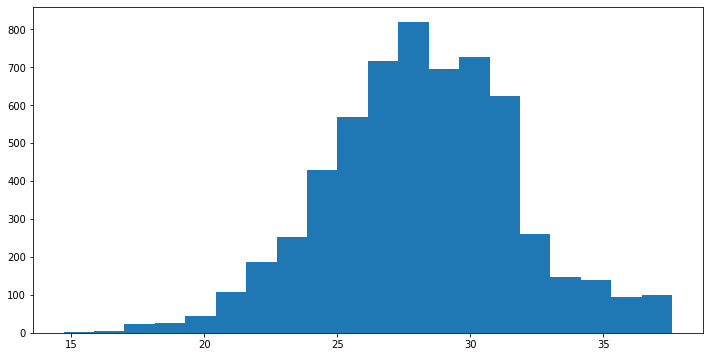

In [90]:
plt.hist(bc_fitted_feature, bins=20)

Now, let's do the same thing but with Yeo-Johson. We can note that the optimal lambda is the same along with the output. Due to its simplicity, it is better to use Box Cox unless you have data which does not have strictly positive values.

In [91]:
yj_fitted_feature, yj_fitted_lambda = stats.yeojohnson(feature)

yj_fitted_lambda

0.1910714444440362

(array([  2.,   6.,  23.,  27.,  44., 107., 186., 251., 430., 569., 715.,
        818., 694., 727., 623., 260., 147., 138.,  93., 100.]),
 array([14.71911242, 15.86241926, 17.0057261 , 18.14903294, 19.29233979,
        20.43564663, 21.57895347, 22.72226031, 23.86556716, 25.008874  ,
        26.15218084, 27.29548768, 28.43879452, 29.58210137, 30.72540821,
        31.86871505, 33.01202189, 34.15532874, 35.29863558, 36.44194242,
        37.58524926]),
 <a list of 20 Patch objects>)

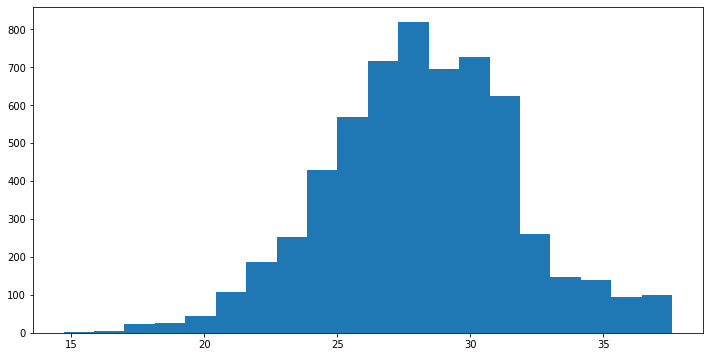

In [92]:
plt.hist(yj_fitted_feature, bins=20)

Lastly, let's do the normal test one last time with the optimal lambda found by `scipy`. We can see that the test statistic still exceeds the cut off of 0.05 by far, but is much better than what we were dealing with previously.

In [93]:
stats.normaltest(yj_fitted_feature)

NormaltestResult(statistic=10.847274655668734, pvalue=0.004411072914542767)

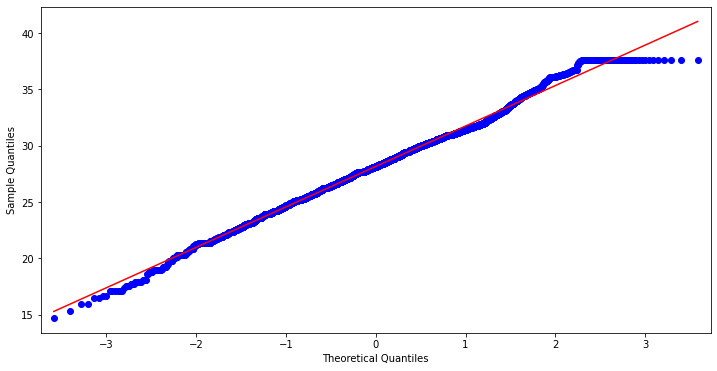

In [94]:
qqplot(yj_fitted_feature, line='s')
pyplot.show()

## Apply transformations on train and test data separately
So, before we continue let's quickly just apply a simple transform to all of our variables. We will just standardize them for now. Remember that you should be doing any transformations separately to your train data and test data. You want to try to keep your test data as pure as possible. If you make transformations before, you risk not having a truly representative sample of new unseen data to test your model on.

In [95]:
numeric_vars = ["LOAN",	"MORTDUE",	"VALUE",	"YOJ",	"DEROG",	"DELINQ", "CLAGE",	"NINQ",	"CLNO",	"DEBTINC"]	
X_train.loc[:,numeric_vars] = X_train.select_dtypes(include='float64').apply(standardize)
X_test.loc[:,numeric_vars] = X_test.select_dtypes(include='float64').apply(standardize)
X_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero
5737,2.325395,-1.371827,-0.702523,DebtCon,Other,1.573086,-0.280591,-0.370877,0.347227,-0.751321,0.987005,1.039073,True
5734,2.315916,-1.632269,-0.666393,HomeImp,Office,-0.234394,-0.280591,-0.370877,1.683315,-0.751321,-0.227091,-3.137607,True
248,-1.229273,-0.189402,-1.709185,HomeImp,Mgr,-0.512468,-0.280591,0.555442,-0.143052,-0.097617,-1.340012,0.132794,True
3480,-0.006467,0.421246,0.357812,DebtCon,ProfExe,-0.234394,-0.280591,-0.370877,-0.309981,0.556087,-0.024742,-1.852545,True
2488,-0.338236,-0.182201,-0.314752,DebtCon,Office,-0.373431,-0.280591,-0.370877,-0.714862,-0.097617,-0.227091,-1.728760,True


## Encoding nominal features using weight-of-evidence coding

Weight of evidence encoding or WoE can be used to check if a variable hasp predictive power and can replace categories with that predictive power. Let's say we are computing a binary classification problem and we want to use this method to encode a categorical variable. We would first take the percent chance of y=0 (Good) and y=1 (Bad) for each category. Bad and good are often used because WoE comes from the credit scoring industry. We will then divide these two percents and take their natural logarithm. This is the WoE for that particular category, represented mathematically below:

$$ WOE_{cat} = ln\bigg(\frac{\text{% Good}}{\text{% Bad}}\bigg) $$


As you can see from this equation, this is a simple way to represent which categories contain the most cases of y=0 or y=1. This is then assumed to be the predictive power of the variable.

Note that you could do this will a continuous variable as well, you would just have to "bin" the variable. For example, if you had income as a continuous variable, you can determine cut-offs for "low earners", "medium earners" and "high earners" or whatever split makes most sense for your case.

When you do your regression, you will now replace each bin or category with its respective WoE and perform the regression. The benefits of this include the ability to combine bins with similar WoE values and create more monotonic relationships which are easy to model. The drawbacks are possible loss of information and lack of ability to findd correlation between variables.

### Information Value
After calculating WoE, we can then calculate information value (IV) for a feature. This value will help us understand if the variable is useful in our prediction at all. It is calculated by finding the difference in the chance y=1 and y=0 multiplied by the WoE for each category, then summing all of these values for categories together.
 
$$ IV = \sum_{cat} \bigg( \big( p(\text{BAD})_{cat} - p(\text{GOOD})_{cat} \big) * \text{WOE}_{cat} \bigg) $$

### Adjusted Weight of Evidence
There is also an alternative way to calculate WoE and handle missing WoE, this is called Adjusted Weight of Evidence:

$$ ln \bigg(\frac{\text{number of non-events}+0.5}{\text{number of events} + 0.5} \div \frac{\text{number of events} + 0.5}{\text{number of events}} \bigg) $$

- showcase frequency counts / bar char of feature JOB as opener
- present and describe from scratch implementation
  - if you find the time, you could rework the from scratch implementation such that it functions more like a standard scaler class
  - eg have methods `transform()` , `fit_transform()` etc.
  - Ideally, one would then want to have a class, but this might go too far
- apply from scratch implementation to JOB and calculate IV
- create two logit models, one with JOB dummy-encoding another with JOB WOE encoded and compare their results
  - run vanilla ML pipeline with train-test split and AUC evaluation 
  - use statsmodel logit to also show regression results
- brief conclusion, stress that WOE is even more useful when having high-cardinal categories


### WOE from scratch

Of course, there are pre-made functions that we can use to calculate WoE. However, as usual we will try to create this by scratch initially so you can see the inner mechanics of WoE. Let's first examine the counts of each of the possible categories of `JOB`.



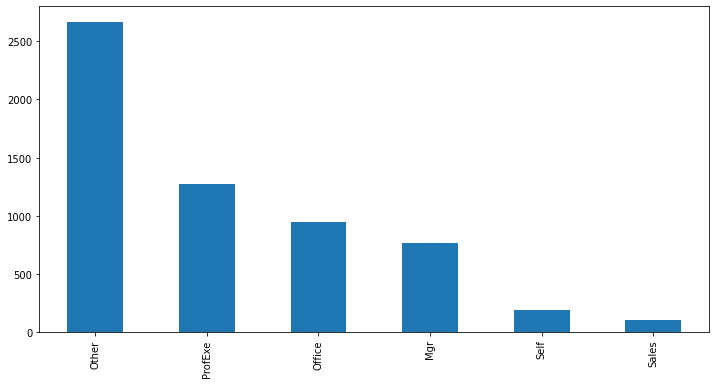

In [96]:
df['JOB'].value_counts().plot(kind='bar')

#### Object Creation
Instead of creating multiple functions and putting them together as we have done in the past, we are instead going to do something that is much more common in Python. We will create a new class and new methods/attributes. Note that each class starts with `class` then a name. You will then have to use `__init__` by convention to describe the initial arguments for the class. Note that `self` is always the first argument of everything in a class. This means that the originally set arguments will always be referenced after the object's initial creation. We recommend trying to create an object on your own to gain a much better understanding of how classes, methods and attributes work.

In [97]:
class IV_Calc:
  def __init__(self, df, feature, target):
    self.feature = feature
    self.target = target
    self.data_head = df.head()

  def count_values(self):
    data = pd.DataFrame()
    data['Count'] = df[self.feature].value_counts()               # Count instances of each category, create row for each
    data['Bad'] = df.groupby([self.feature])[self.target].sum()   # Count y=1 instances of that category
    data['Good'] = data['Count'] - data['Bad']                    # Count y=0 instances of that category
    data = data.sort_values(by=["Count"], ascending=False)
    
    try:
      assert data["Bad"].sum() != 0                               # Check that there are y=1 instances in sample
      assert data["Good"].sum() != 0                              # Check that there are y=0 instances in sample
      assert np.isin(df[self.target].unique(), [0, 1]).all()      # Check that target includes only 0,1 or True,False
    except:
      print("Error: Target must include 2 binary classes.")
      raise                                                       # Stop running if one of the above conditions is not satisfied
    
    return data

  def distribution(self):
    data = self.count_values()
    data['Ratio Bad'] = data['Bad'] / data['Count']
    data['Ratio Good'] = data['Good'] / data['Count']
    data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()    # Of all y=0 instances, what percentage are from each category?
    data["Distribution Good"] = data["Good"] / data["Good"].sum() # Of all y=1 instances, what percentage are from each category?
    data = data.sort_values(by=["Count"], ascending=False)
    return data.iloc[:,-2:]
  
  def woe(self):
    data = self.distribution()
    data['WOE'] = np.log(data["Distribution Good"] / data["Distribution Bad"])
    data.replace({"WOE": {np.inf: 0, -np.inf: 0}})  # If no instances are bad, this will replace values of infinity with 0
    data = data.sort_values(by=["WOE"], ascending=False)
    return data.iloc[:,-1]
  
  def woe_adj(self):
    data = self.count_values()
    data["WOE_adj"] = np.log( 
        ((data["Count"] - data["Bad"] + 0.5) / (data["Count"].sum() - data["Bad"].sum())) / 
        ((data["Bad"] + 0.5) / data["Bad"].sum())
    )
    data.replace({"WOE_adj": {np.inf: 0, -np.inf: 0}})
    data = data.sort_values(by=["Count"], ascending=False)
    return data.iloc[:,-1]
  
  def IV_per_cat(self):
    data = self.distribution()
    data['WOE'] = self.woe()
    data["IV"] = data["WOE"]*(data["Distribution Good"] - data["Distribution Bad"])
    data = data.sort_values(by=["IV"], ascending=False)
    return data.iloc[:,-1]
  
  def full_summary(self):
    data = self.count_values()
    data['Ratio Bad'] = data['Bad'] / data['Count']
    data['Ratio Good'] = data['Good'] / data['Count']
    data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
    data["Distribution Good"] = data["Good"] / data["Good"].sum()
    data['WOE'] = self.woe()
    data["WOE_adj"] = self.woe_adj()
    data["IV"] = self.IV_per_cat()
    data = data.sort_values(by=["Count"], ascending=False)
    return data

  def final_assessment(self):
    data = self.full_summary()
    iv = data["IV"].sum() # final IV value
    if iv < .02:
      print("The variable " + self.feature + " is not predictive with an IV of: {}".format(iv))
    elif iv < .1:
      print("The variable " + self.feature + " is weakly predictive with an IV of:{}".format(iv))
    elif iv < .3:
      print("The variable " + self.feature + " is moderately predictive with an IV of:{}".format(iv))
    else :
      print("The variable " + self.feature + " is highly predictive with an IV of: {}".format(iv))
    return iv

In [98]:
train_df = pd.concat([X_train, y_train], axis=1)

woe_job = IV_Calc(train_df, feature="JOB", target="BAD")

woe_job.full_summary()

,Count,Bad,Good,Ratio Bad,Ratio Good,Distribution Bad,Distribution Good,WOE,WOE_adj,IV
Other,2667,577,2090,0.216348,0.783652,0.485282,0.438063,-0.102366,-0.102993,0.004834
ProfExe,1276,212,1064,0.166144,0.833856,0.178301,0.223014,0.223761,0.221875,0.010005
Office,948,125,823,0.131857,0.868143,0.105130,0.172501,0.495199,0.491814,0.033362
Mgr,767,179,588,0.233377,0.766623,0.150547,0.123245,-0.200102,-0.202042,0.005463
Self,193,58,135,0.300518,0.699482,0.048780,0.028296,-0.544612,-0.549498,0.011156
Sales,109,38,71,0.348624,0.651376,0.031960,0.014882,-0.764350,-0.770404,0.013054


In [99]:
woe_job.final_assessment()

The variable JOB is weakly predictive with an IV of:0.07787316133784931


0.07787316133784931

We can now plot the WoE for each category and see how they compare. Keep in mind that this variable is only weakly predictive for our scenario. We can check the WoE for each of the categories as well. At this point we should decide whether it is actually worth it to continue using it in our analysis. If we do, we can replace these categories with their respective WoE values.

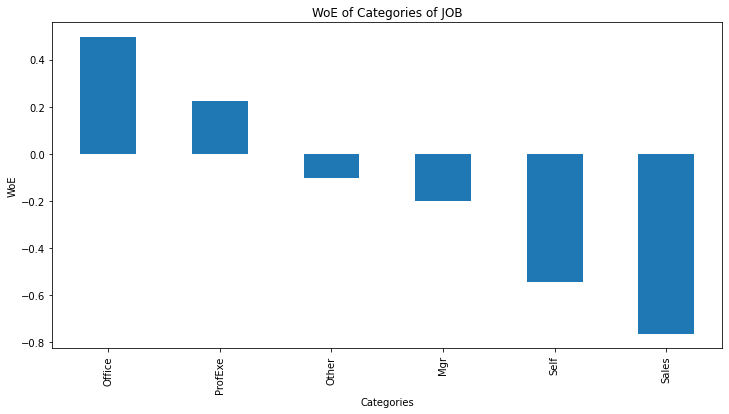

In [100]:
woe_job.woe().plot(kind="bar", title="WoE of Categories of JOB", ylabel="WoE", xlabel="Categories")

### WoE using scorecardpy

If you would like a quick implementation of the above, you can check out the package scorecardpy. You can view the documentation [here](https://pypi.org/project/scorecardpy/). 

In [101]:
!pip install scorecardpy
import scorecardpy as sc

[INFO] creating woe binning ...


{'CLAGE': <Figure size 864x432 with 2 Axes>}

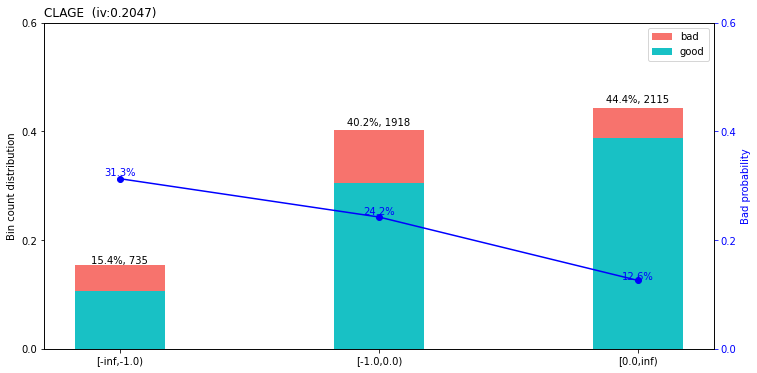

In [102]:
woe = sc.woebin(train_df, y="BAD", x='CLAGE')
sc.woebin_plot(woe)

In [103]:
sc.woebin_ply(X_train, woe) # if you would like to replace a variable with its WoE, scorecard has an easy function to do so

[INFO] converting into woe values ...


,NINQ,DEROG,VALUE,REASON,LOAN,JOB,CLNO,DELINQ,MORTDUE,DEBTINC,YOJ,DEROGzero,CLAGE_woe
0,-0.097617,-0.280591,-1.211918,HomeImp,-1.646354,Other,-1.238838,-0.370877,-1.182359,0.132794,0.252235,True,0.590143
1,-0.751321,-0.280591,-0.633530,HomeImp,-1.627396,Other,-0.732965,1.481760,-0.061755,0.132794,-0.234394,True,0.237274
2,-0.097617,-0.280591,-1.651493,HomeImp,-1.608437,Other,-1.137663,-0.370877,-1.495772,0.132794,-0.651505,True,0.237274
3,-0.097617,-0.280591,-0.223283,IsMissing,-1.608437,Other,-0.125917,-0.370877,-0.189402,0.132794,-0.234394,True,0.237274
5,-0.097617,-0.280591,-1.186420,HomeImp,-1.589479,Other,-1.340012,-0.370877,-1.063485,0.481849,0.043679,True,0.237274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,-0.751321,-0.280591,-0.141856,DebtCon,3.927365,Other,-0.631790,0.555442,-0.597651,0.132794,0.877901,True,-0.562282
5956,-0.751321,-0.280591,-0.150401,DebtCon,3.927365,Other,-0.631790,-0.370877,-0.454206,0.291207,1.016938,True,-0.562282
5957,-0.751321,-0.280591,-0.150657,DebtCon,3.927365,Other,-0.631790,-0.370877,-0.467670,0.245072,0.877901,True,-0.562282
5958,-0.751321,-0.280591,-0.171588,DebtCon,3.927365,Other,-0.530615,-0.370877,-0.560858,0.060199,0.738864,True,-0.562282


# Feature Selection

## Filter methods
Filters are statistical methods which test variables one by one and their relevance to the task at hand. Since they are relatively easy to compute, they tend to be checked first. The next methods of feature selection require more computational power, therefore eliminating variables using filters first will save time later.

Let's recall the chart we saw in class. The columns represent the target, is it continuous or discrete? The rows represent the variable to test, is it continuous or discrete/categorical? The best test is the one that corresponds to the right row/column.

```
Data Types      | CONTINUOUS TARGET     | DISCRETE TARGET
-------------------------------------------------------------------------------
CONTINUOUS VAR  | Pearson Correlation   | Fisher Score
CATEGORICAL VAR | Fisher Score / ANOVA  | Chi-Square / Cramer's V/ IV/ Gain
```



### Pearson Correlation
This is probably the most common correlation metric used. It is often just called correlation. It is remarkable for its very simple implementation:

$$ \rho = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2 \sum_{i=1}^{n} (y_i - \overline{y})^2}} $$

This correlation is best used when target and the variable to check are **both continuous**. The coefficient produced is bound between -1 and 1. It is recommended to only keep variables with a high correlation, however there is no rule that you can always follow. The closer that this coefficient is to 0, the less correlation between the variable and the target.



### Fisher Score
This method of finding correlation can be used if **either** the target or variable in question is binary. It generalizes into an ANOVA test if there are multiple categories.

$$ FS = \frac{|\bar{x}_G - \bar{x}_B |}{\sqrt{s^2_G + s^2_B}} $$

### Analysis of Variance (ANOVA)
ANOVA specifically compares the means of a **feature with more than 2 categories with a continuous target**. For example, we had the feature `JOB`. If our target was continuous, ANOVA would be testing if each category in `JOB` actually corresponded to a different mean in our target. 

So, we first find the sum of squares between categories:
$$ SSD_B = \sum_{i=1}^k \sum_{j=1}^n \left(\bar{x}_i - \bar{x}_.\right)^2 = n\sum_{i=1}^k \left(\bar{x}_i - \bar{x}_.\right)^2 $$

We then find the sum of square difference within categories:
$$ SSD_W = \sum_{i=1}^k\sum_{j=1}^n \left(x_{ij} - \bar{x}_i \right)^2 $$

Now we divide the $ SSD_B $ by its degree of freedom: k categories minus 1. This gives us the mean $ SSD_B $. And then we divide $ SSD_W $ by its degrees of freedom, number of observations minus k categories. This gives us the mean $ SSD_W $.

$$ \mu_B = \frac{SSD_B}{k-1} $$

$$ \mu_W = \frac{SSD_W}{n-k} $$

Now we have the F-stastic that we can use.
$$ F = \frac{\mu_B}{\mu_W} $$

We must compare this value to the [F-Distribution Table](http://www.socr.ucla.edu/Applets.dir/F_Table.html) and decide whether we want to include it in the analysis.



### Chi-Square Analysis

Chi Square tests whether events are dependent on one another. If there is no dependence between the target and the feature, it becomes more unlikely that it would actually would be meaninigful to include in the analysis.

$$ \chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}} $$

Chi square is only used when **both the feature of interest and the target are both categorical variables**. You must use a [chi-square table](https://web.ma.utexas.edu/users/davis/375/popecol/tables/chisq.html) (this one is alpha = 0.10) to assess whether you would like to include this varible in the end or not. Remember that if one category has too little observations, this test's results may not be accurate.

### Cramer's V

This method is always bound between 0 and 1. Higher values are more predictive with a threshold of 0.1 being the most common.

$$ V = \sqrt{\frac{\chi^2}{n}} $$

Cramer's V is based on Chi-Square, which means **both the feature of interest and the target are both categorical variables**. This value is always bound between 0 and 1. A higher value indicates higher preditive power. A threshold of 0.1 is common.




### Information Value

This is the value that we calculated before in the section on Weight of Evidence. The main purpose of this value was to assess the preditive power of a **categorical variable and a binary target**. 

$$ IV = \sum_{cat} \bigg( \big( p(\text{BAD})_{cat} - p(\text{GOOD})_{cat} \big) * \text{WOE}_{cat} \bigg) $$

Generally, the following tells you the usefulness of an IV variable's score:

IV < 0.02: not predictive

0.02 – 0.1: weak predictive ability

0.1 – 0.3: medium predictive ability

0.3 < IV: strong predictive ability



### Information Gain / Entropy

Entropy normally means chaos. In machine learning, it is defined as an equal chance of selecting any category of the target variable. If you have a set of observations and there is an equal mix of all target labels in this set, entropy is maximized. If you can find some feature split to cause only one target label in each section of data, then entropy is minimized. Information Gain is the difference between the entropy before and the sum of entropy in each group after a split. As such, this method is most appropriate for **both a discrete feature and discrete target**.

Entropy is calculated by the following formula:

$$ E = -\sum^C_i p_i \cdot log_2(p_i) $$

Then information gain can be defined as the sum of entropy in total minus entropy of each category separately (this is the same as entropy in a decision tree):

$$ \text{Info Gain} = E_\text{total} - \sum{E_\text{category}}  $$

It is up to you to decide how little information gain to tolerate to consider a variable to be helpful.

Now that we know some of these methods, let's see what they look like in some code from scratch. Note that the function below is not made to deal with every type of data (especially if the target is a variable with multiple categories). However, we can see quite a lot of the decisions that you will need to make behind the scenes for it to all work.

In [104]:
class filter_binary_target:
  def __init__(self, df, target):
    self.target = target
    self.data_head = df.head()
  
  def auto_filter_binary_target(self):
    print('Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.')
    data_no_target = df.drop(columns=self.target)
    columns = ['Data Type', 'Metric', 'Score']
    index = data_no_target.columns
    result = pd.DataFrame(index=index, columns=columns)

    for col in data_no_target:
      if data_no_target.dtypes[col] == 'bool' or data_no_target.dtypes[col].name == 'category':
        result.loc[col, 'Data Type'] = "discrete"
        result.loc[col, 'Metric'] = "IV"
        result.loc[col, 'Score'] = self.IV_binary_target(feature=col)

      if data_no_target.dtypes[col] == 'int64' or data_no_target.dtypes[col] == 'float64':
        result.loc[col, 'Data Type'] = "continuous"
        result.loc[col, 'Metric'] = "Fisher"
        result.loc[col, 'Score'] = self.fisher_binary_target(feature=col)

    return result

  def IV_binary_target(self, feature): # same code as used above
    data = pd.DataFrame()
    
    data['Count'] = df[feature].value_counts()
    data['Bad'] = df.groupby([feature])[self.target].sum()
    data['Good'] = data['Count'] - data['Bad']
    
    data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
    data["Distribution Good"] = data["Good"] / data["Good"].sum()
    
    data['WOE'] = np.log(data["Distribution Good"] / data["Distribution Bad"])
    data.replace({"WOE": {np.inf: 0, -np.inf: 0}})
    
    data["IV"] = data["WOE"] * (data["Distribution Good"] - data["Distribution Bad"])
    
    iv = data["IV"].sum()
    
    return iv

  def fisher_binary_target(self, feature):
    mu_0 = df.groupby(df[self.target])[feature].mean()[0]
    mu_1 = df.groupby(df[self.target])[feature].mean()[1]
    var_0 = df.groupby(df[self.target])[feature].var()[0]
    var_1 = df.groupby(df[self.target])[feature].var()[1]

    num = abs(mu_0 - mu_1)
    den = (var_0 + var_1) ** 0.5
    score = num/den
    
    return score

  def pearson(self, feature): # since our target is binary, we actually don't need this. However, if you would like to expand this class, you can use this code
    mean_feature = df[feature].mean()
    mean_target = df[self.target].mean()
    num = ((df[feature] - mean_feature)*(df[self.target] - mean_target)).sum()
    den = (((df[feature] - mean_feature)**2).sum() * ((df[self.target] - mean_target)**2).sum()) ** .5
    rho = num/den
    return rho

In [105]:
test = filter_binary_target(df=train_df, target="BAD")

test.auto_filter_binary_target()

Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.


,Data Type,Metric,Score
LOAN,continuous,Fisher,0.13309
MORTDUE,continuous,Fisher,0.0951093
VALUE,continuous,Fisher,0.106516
REASON,discrete,IV,0.00861846
JOB,discrete,IV,0.0778732
YOJ,continuous,Fisher,0.0979491
DEROG,continuous,Fisher,0.358356
DELINQ,continuous,Fisher,0.473846
CLAGE,continuous,Fisher,0.324169
NINQ,continuous,Fisher,0.275753


So let's analyze this output. We cannot directly compare IV and Fisher scores but we can judge them relative to other variables calculated with the same score. We can see that of our 3 variables tested with IV, `REASON` is particularly weak and does not pass the 0.02 value threshold for IV. Therefore, we should eliminate it from the analysis. We can also see that of the variables for which we calculated a Fisher score, `CLNO`, `MORTDUE` and `YOJ` are all quite low.

At this point we could choose to eliminate these variables. However, let's leave them in for a little check using wrapper methods. 

# One-Hot Encoding

Before we continue to the next section which will fit models, we need to prepare out data for them. We will quickly convert categorical variables to one hot encoded variables using pandas `get_dummies` method on a DataFrame column.

In [106]:
reason = pd.get_dummies(X_train.REASON, prefix='REASON') # Create dummy columns for REASON
job = pd.get_dummies(X_train.JOB, prefix='JOB') # Create dummy columns for JOB
X_train.drop(['REASON', 'JOB'], axis=1, inplace=True) # Drop original columns
X_train = pd.concat([X_train, reason, job], axis=1) # Combine it all together

X_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_DebtCon,REASON_HomeImp,REASON_IsMissing,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5737,2.325395,-1.371827,-0.702523,1.573086,-0.280591,-0.370877,0.347227,-0.751321,0.987005,1.039073,True,1,0,0,0,0,1,0,0,0
5734,2.315916,-1.632269,-0.666393,-0.234394,-0.280591,-0.370877,1.683315,-0.751321,-0.227091,-3.137607,True,0,1,0,0,1,0,0,0,0
248,-1.229273,-0.189402,-1.709185,-0.512468,-0.280591,0.555442,-0.143052,-0.097617,-1.340012,0.132794,True,0,1,0,1,0,0,0,0,0
3480,-0.006467,0.421246,0.357812,-0.234394,-0.280591,-0.370877,-0.309981,0.556087,-0.024742,-1.852545,True,1,0,0,0,0,0,1,0,0
2488,-0.338236,-0.182201,-0.314752,-0.373431,-0.280591,-0.370877,-0.714862,-0.097617,-0.227091,-1.728760,True,1,0,0,0,1,0,0,0,0


In [107]:
# same process as above for test set

reason = pd.get_dummies(X_test.REASON, prefix='REASON')
job = pd.get_dummies(X_test.JOB, prefix='JOB')
X_test.drop(['REASON', 'JOB'], axis=1, inplace=True)
X_test = pd.concat([X_test, reason, job], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Wrappers
Unlike filter methods which check one variable at a time with a statistical framework, wrappers try to iteratively build models in different ways to detect variables which most impact a model's performance. As you can imagine, there are two major ways to do this.
1. You add variables one at a time
2. You remove variables one at a time

Each time you are double checking how the model performs with the inclusion or exclusion of a certain variable.

In [108]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train,  np.ravel(y_train.values))
y_pred = clf.predict(X_test)
(np.vstack(y_pred) == np.array(y_test)).mean()

0.8548657718120806

### Stepwise regression (forward regression)
We will start with the first wrapper method described above. We can easily create this with a for-loop, but we will spare you the complexities by using `mlxtend` to sequentially add our possible features to the model using the function `SequentialFeatureSelector`. The machine will add variables one at a time and double check the model's performance. 

Note that unfortunately `sklearn` does not yet support stepwise regression. However, if you'd like, there are ways to code it yourself through a loop that tries to find the best combination of variables through iterative model building like the [second answer to this StackExchange question](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm).

Let's use the algorithm from `mlextend` and check whether it corresponds to the features that our filter model also chose.



In [109]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=888, max_iter=200)
sfs = SFS(clf, 
           k_features=(3,18), 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=0)

sfs = sfs.fit(X_train, np.ravel(y_train.values))

In [110]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (ACC: 0.842): ('LOAN', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'DEROGzero', 'REASON_DebtCon', 'REASON_HomeImp', 'REASON_IsMissing', 'JOB_Mgr', 'JOB_ProfExe', 'JOB_Self')



We can see from this regression, `MORTDUE` and most of the one-hot variables for `REASON` were eliminated. However, `YOJ` and `CLNO`, which were candidates to drop according to our filters, were kept. This may be because there are some variable interaction which we cannot observe using filter methods. It would be up to the analyst to try all combinations and determine the one that works best for the data.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


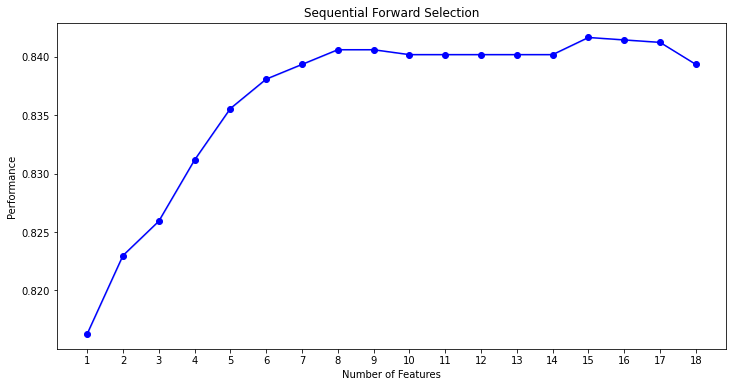

In [111]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')

plt.show()

Lastly, let's check the mean error on the test set to see how this selection of features did on unseen data.



In [112]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

clf.fit(X_train_sfs, np.ravel(y_train.values))
y_pred = clf.predict(X_test_sfs)

In [113]:
(np.vstack(y_pred) == np.array(y_test)).mean() # Check mean error

0.8506711409395973

### Recursive feature elimination (backward selection)

Another extremely useful variable selection method is backward selection. We can actually implement it very easily using the `RFECV` function from `sklearn`. You can view the documentation for this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV). Let's see if it selects similar variables as our last wrapper model and the filter model.

In [114]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='accuracy')
X_train_new = rfecv.fit(X_train,  np.ravel(y_train.values))

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 16


In [115]:
X_train.columns[rfecv.support_]

Index(['LOAN', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC',
       'DEROGzero', 'REASON_DebtCon', 'REASON_IsMissing', 'JOB_Mgr',
       'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

In this regresion, many more variables were dropped including `MORTDUE`, `YOJ` and `CLNO`, which were candidates to drop according to our filters. In addition, most of the dummy variables for the categorical variable `REASON` were also dropped. Again. this may be caused by some variable interaction which we cannot observe by using filter methods. It is up to your discretion to experiment with combinations and determine the best course of action to solve you problem.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

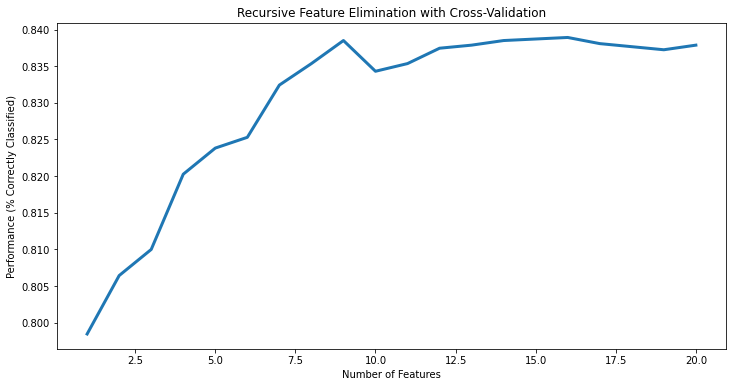

In [116]:
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of Features')
plt.ylabel('Performance (% Correctly Classified)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)

plt.show()

Lastly, let's check the mean error on the test set to see how this selection of feeatures did on unseen data. It is a little lower than the previous wrapper method's findings in this case.

In [117]:
(np.vstack(rfecv.predict(X_test)) == np.array(y_test)).mean() # Check mean error

0.8557046979865772

# Importing from other scripts

Some notebooks can get really long which makes them a bit more tedious to read. If you have already coded something in another notebook and want to refer to it, you can simply import it as a script. For example, we have created the file rf_test_auc.py and inside we have a function. This function will perform a train-test split on data, use the training data to build a random forest and finally use the test set to calculate the AUC. Using this other file, we can simply import the function that we want and run the function to get our results.

In [131]:
from rf_test_auc import RF_test_AUC # this is easiest when the .py file is in your working directory
RF_test_AUC(X_train, y_train, X_test, y_test, n_estimators = 150)

0.9769372861614617

Now you can keep your notebooks nice and neat by leaving out some functions that you had to code yourself whose inner workings are not the most critical for your readers to see right away.

Note that you can use files which are not in your working directory, however this is a bit more complicated. You can find tutorials on how to do this using many tutorials online such as [this one](www.youtube.com/watch?v=A7E18apPQJs). 

# Pipelines

After we have decided how we would like our finalized data to look like in the end, we will likely have to repeat the modifications to our data set several times over (for the train set, test set, new batches of data etc...). In this case, it can be very useful to set up a pipeline which makes the same adjustments to raw data.

In [ ]:
# Let's reload the raw data

data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv' 
df = pd.read_csv(data_url)

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
# Now let's use a pipeline to transform our data using some of what we have learned above

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# If you only want a transformation on select columns, it is good to first use ColumnTransformer
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [3, 4]), # ('step_name', fun(), list_cols) always follow this format for each step of the transfomer
                                              ('scl', StandardScaler(), [0,1,2,5,6,7,8,9,10])], # Note that below RF is used as a classifier, thus, scaling is not exactly necessary
                                              remainder='passthrough')

# Construct some pipelines
pipe = Pipeline([
                ('t', transformer), # ('step_name', transfomer) always follow this format for transformers in the pipeline
                ('clf', RandomForestClassifier()) # ('step_name', fun()) add parantheses for other functions
                ])

In [ ]:
pipe.fit(X_train, y_train.values.ravel())
y_pred = pipe.predict(X_test)

In [ ]:
(np.vstack(y_pred) == np.array(y_test)).mean() # Check mean error

# Conclusions

The above demos should have provided some ideas, what transformation and selection strategies work well for HMEQ. As final experiment, perform a controlled comparison (same train/test data) of logit on the basic data set and a version to which high performing transformations and/or feature selection has been applied. Ideally we could show some performance improvement. If previous results suggest that this will not be the case for HMEQ, then maybe just skip the conclusion part and make this analysis an exercise. 


| Goal | Possible Code |
| --- | --- |
| Get data types of each column | `df.dtypes` |
| Select all float columns of a df | `df.select_dtypes(include='float64')` |
| Create min-max scaling or normalization object | `MinMaxScaler()` |
| Create standardization object | `StandardScaler()` |
| Modify `X` with a Box Cox transformation (positive values only) | `stats.boxcox(X) ` |
| Modify `X` with a Yeo Johnson transformation | `stats.yeojohnson(X)` |
| Test if a variable is normally distributed (p-val > 0.05 points to normality) | `statsnormaltest(X)` |
| Create QQ plot for `X` (lines should correspond) | `qqplot(feature, line='s')` |
| Get WoE weights of `feature_i` | `scorecardpy.woebin(train_df, y="target", x='feature_i')` |
| Plot weights of `woebin` | `scorecardpy.woebin_plot(woebin_obj)` |
| Replace the feature calculated in `woebin` with its results| `scorecardpy.woebin_ply(X_train, woe)` |
| Pearson's coefficient | `stats.pearsonr(X, y)` |
| Calculate Chi2 value for X and y | `chi2(X, y)` |
| Get dummy values for `feature` with prefix `name_` | `pd.get_dummies(X.feature, prefix='name')` |
| Create forward variable selection object | `SequentialFeatureSelector()` |
| Returns `X` of only selected features | `sfs_model.transform(X_train)` |
| Create backward variable selection object | `RFECV()` |
| Use fitted RFECV model to predict on test set | `rfecv_model.predict(X_test)` |
| Create object which uses `fun` on cols in `col_list` and keeps unchanged columns | `ColumnTransformer(transformers=('step_name', fun(), list_cols), remainder='passthrough')` ** |
| Create pipeline object | `Pipeline(('step_name', fun))` ***|
| Pass X_train through pipeline for fitting | `pipe_name.fit(X_train, y_train)`|
| Pass X_test through pipeline for prediction | `pipe_name.fit(X_test)`|


** In `ColumnTransformer`, you can add a list of transformers of that format in the `transformer` argument

*** In `Pipeline`, you can add a list of steps of that format as the first argument. It is encouraged to put your classifier in here as the last step


# Exercises

## Power transformations 
- Box-Cox (BC) and Yeo-Johnson (YJ) transformation exhibit hyperparameter $\lambda$. Implement a custom function that receives a feature as input and grid-searches the best value of $\lambda$. The caller should be able to specify whether s/he wants to use BC or YJ. Your function can assess the merit of a value of $\lambda$ by means of the function `normaltest()`, the use of which we illustrated above. The more normal a feature after the transformation, the better the value of $\lambda$. 

- Write another custom function `best_transform()`. Given a DataFrame with input data, your function should identify the best power transformation for each numerical feature. Note that using the raw feature without transformation is also possible and might be the best approach. Also remember to tune $\lambda$ when needed using your solution to the previous exercise. Try out your function using the HMEQ data. Display the best transformation for each feature.

**Optional** 
- Till here, we have assessed the merit of a transformation by means of checking normality using `normaltest()`. Arguably, a better approach for predictive modeling would be to test if a model trained on the transformed data generates better predictions. To implement this logic, you need a custom function that implements our standard predictive modeling pipeline (see, e.g., Tutorial 5 or Tutorial 7) to estimates the predictive performance of a model, say logistic regression, on an input data set. Once you have this function, you can revise your solutions to the previous exercises such that they call the function just implemented instead of `normaltest()`. 
- Test your function using the HMEQ data set
- Perform a final test what approach gives better results (in terms of AUC on HMEQ) optimizing feature transformations using `normaltest()` or by assessing predictive accuracy. *For the experts, make sure to not overfit* 
---
## Weight of evidence coding (challenging)
A standard risk modeling workflow in banking is the following
- Discretize all numeric features in a data set
- Optimize categorical features by re-grouping/merging category levels
- WOE transform all categorical variables
- Build logistic regression-based scorecard

Your task is to implement this workflow. The previous demos provide much of the functionality that you need. However, some extensions are needed and you have to put everything together. To keep things manageable, let's agree on the following heuristic:
Implement step 1 and step 2 by fitting a shallow tree to the data (e.g., at most 5 leaf nodes). This will work with numerical and categorical features alike. The leaf nodes of your shallow tree represent the new, re-grouped, optimized categorical features. After this tree-based transformation, you can WOE-encoded the whole data set in one go.

Compare a logit model using your transformed data set to one from our standard version of the data [add link here]

## Feature selection
- We discussed that sklearn does not offer stepwise regression. Implement a stepwise logit using AIC from scratch. To that end, you will need to decide on a search direction (forward or backward) and scoring criterion. The latter is needed for selecting the next feature to be added to or deleted from a model. Understanding the role of the search criterion is a very good learning outcome in its own right. There is probably no single correct or best solution how to score candidate features. Try to come up with a sensible approach.  